# Population Change 2020-2021

### ACS Data

Part 1 of this notebook demonstrates how to query and merge the same data
set from different years. It also demonstrates how, behind the 
scenes, `censusdis` loads metadata and works across multiple
years. Nothing is hard-coded in the library about what variables
or data sets are available in what years. So when the 2021 data
was published, this notebook just worked.

However, it also demonstrates some issues one must be keenly aware
of when looking at ACS data. ACS5 data covers a wide range of variables,
but it also computes representative numbers over a five year time
period, not numbers as of a specific data as some other data sets do.
So the values presented in the 2020 data set are based on survey
results from 2016, 2017, 2018, 2019, and 2020. If we compare 2021 ACS5
to 2020 ACS5, 4/5 of the sample comes from 2017, 2018, 2019 and 2020 
in both. In the 2020 data set, there is also data from 2016, whereas in
the 2021 data set there is also data from 2021. 

### PEP Data

Part 2 looks at the Population Estimates (PEP) data set, which seeks to
estimate population at a specific point in time, specifically June 1 of
each year. It also tracks changes from the previous year in both numeric
and percentage terms. 

As we can see by comparing the data and maps in parts 1 and 2, it is 
important to understand not just what was measured in each data set,
but how. Look at the difference in New York State for a particularly
extreme difference based on which data set we look at.

In [1]:
# So we can run from within the censusdis project and find the packages we need.
import os
import sys

sys.path.append(
    os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir)))
)

## Imports and configuration

In [2]:
import censusdis.data as ced
import censusdis.maps as cem

from censusdis.states import STATE_NY

# Part 1: Using ACS5 Data

In [3]:
DATASET_ACS5 = "acs/acs5"

In [4]:
TOTAL_POPULATION_VARIABLE = "B01003_001E"

## Download the popluation of the states in both years

In [5]:
gdf_states_2020 = ced.download_detail(
    DATASET_ACS5,
    2020,
    ["NAME", TOTAL_POPULATION_VARIABLE],
    state="*",
    with_geometry=True,
)

# Note that we don't load the geometry here.
# We already have it above, and it will
# still be available after the merge.
df_states_2021 = ced.download_detail(
    DATASET_ACS5, 2021, ["NAME", TOTAL_POPULATION_VARIABLE], state="*"
)

## Merge the two data sets and compute how the populations changed

In [6]:
gdf_both_years = gdf_states_2020.merge(
    df_states_2021, on=["STATE", "NAME"], suffixes=("_2020", "_2021")
)

In [7]:
TOTAL_POPULATION_2020_VARIABLE = f"{TOTAL_POPULATION_VARIABLE}_2020"
TOTAL_POPULATION_2021_VARIABLE = f"{TOTAL_POPULATION_VARIABLE}_2021"

TOTAL_POPULATION_CHANGE = f"{TOTAL_POPULATION_VARIABLE}_DELTA"
TOTAL_POPULATION_CHANGE_PERCENT = f"{TOTAL_POPULATION_CHANGE}_PERCENT"

In [8]:
gdf_both_years[TOTAL_POPULATION_CHANGE] = (
    gdf_both_years[TOTAL_POPULATION_2021_VARIABLE]
    - gdf_both_years[TOTAL_POPULATION_2020_VARIABLE]
)

gdf_both_years[TOTAL_POPULATION_CHANGE_PERCENT] = (
    100
    * gdf_both_years[TOTAL_POPULATION_CHANGE]
    / gdf_both_years[TOTAL_POPULATION_2020_VARIABLE]
)

## Fastest growing states

### Absolute

In [9]:
gdf_both_years.sort_values(TOTAL_POPULATION_CHANGE, ascending=False)[
    ["NAME", TOTAL_POPULATION_CHANGE]
].head()

,NAME,B01003_001E_DELTA
4,New York,599896
29,New Jersey,348606
24,Texas,227139
0,Pennsylvania,175765
7,Florida,122838


### Percentagewise

In [10]:
gdf_both_years.sort_values(TOTAL_POPULATION_CHANGE_PERCENT, ascending=False)[
    ["NAME", TOTAL_POPULATION_CHANGE_PERCENT]
].head()

,NAME,B01003_001E_DELTA_PERCENT
29,New Jersey,3.923349
19,Idaho,3.263285
42,Rhode Island,3.228499
4,New York,3.074049
32,Vermont,2.770446


## Fastest shrinking states

### Absolute

In [11]:
gdf_both_years.sort_values(TOTAL_POPULATION_CHANGE, ascending=True)[
    ["NAME", TOTAL_POPULATION_CHANGE]
].head()

,NAME,B01003_001E_DELTA
16,Arizona,-94861
33,North Carolina,-19205
5,District of Columbia,-18820
39,Mississippi,-14812
8,South Carolina,-12614


### Percentagewise

In [12]:
gdf_both_years.sort_values(TOTAL_POPULATION_CHANGE_PERCENT, ascending=True)[
    ["NAME", TOTAL_POPULATION_CHANGE_PERCENT]
].head()

,NAME,B01003_001E_DELTA_PERCENT
5,District of Columbia,-2.681011
16,Arizona,-1.322277
15,Wyoming,-0.809670
39,Mississippi,-0.496741
2,West Virginia,-0.352822


## Plot on maps

Text(0.5, 1.0, 'Total Population Change by State, 2020-2021')

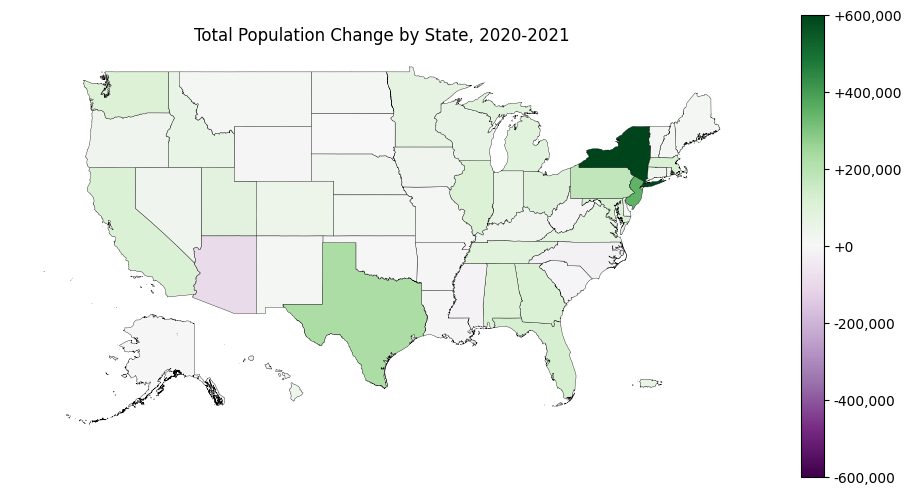

In [13]:
from matplotlib.ticker import FuncFormatter

ax = cem.plot_us(
    gdf_both_years,
    TOTAL_POPULATION_CHANGE,
    legend=True,
    figsize=(12, 6),
    cmap="PRGn",
    edgecolor="black",
    linewidth=0.25,
    vmin=-600_000,
    vmax=600_000,
    legend_kwds={"format": FuncFormatter(lambda x, pos: f"{x:+,.0f}")},
)

ax.axis("off")
ax.set_title("Total Population Change by State, 2020-2021")

Text(0.5, 1.0, 'Total Population Percentage Change by State, 2020-2021')

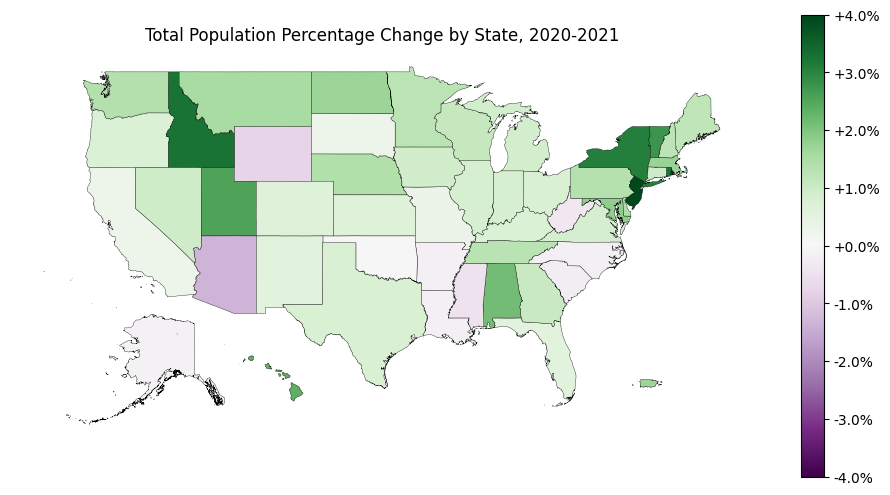

In [14]:
ax = cem.plot_us(
    gdf_both_years,
    TOTAL_POPULATION_CHANGE_PERCENT,
    legend=True,
    figsize=(12, 6),
    cmap="PRGn",
    edgecolor="black",
    linewidth=0.25,
    vmin=-4,
    vmax=4,
    legend_kwds={"format": FuncFormatter(lambda x, pos: f"{x:+.1f}%")},
)

ax.axis("off")
ax.set_title("Total Population Percentage Change by State, 2020-2021")

# Part 2: Using the Population Estimates Dataset

Instead of using two different years of the ACS5 data set, we could also use a specialized
U.S. Census Data Set that estimates population and population change. It is called 
`pep/population` and is described at https://api.census.gov/data/2021/pep/population.html.

In [15]:
DATASET_PEP = "pep/population"

In [16]:
# See https://api.census.gov/data/2021/pep/population/variables.html

POP_2020_VARIABLE = "POP_2020"
POP_2021_VARIABLE = "POP_2021"
NUM_CHANGE_VARIABLE = "NPOPCHG_2021"
PCT_CHANGE_VARIABLE = "PPOPCHG_2021"

PEP_VARIABLES = [
    "NAME",
    POP_2020_VARIABLE,
    POP_2021_VARIABLE,
    NUM_CHANGE_VARIABLE,
    PCT_CHANGE_VARIABLE,
]

In [17]:
gdf_pep = ced.download_detail(
    DATASET_PEP, 2021, PEP_VARIABLES, state="*", with_geometry=True
)

## Fastest growing states

### Absolute

In [18]:
gdf_pep[["NAME", NUM_CHANGE_VARIABLE]].sort_values(
    NUM_CHANGE_VARIABLE, ascending=False
).head()

,NAME,NPOPCHG_2021
10,Texas,310288
40,Florida,211196
45,Arizona,98330
15,North Carolina,93985
25,Georgia,73766


### Percentagewise

In [19]:
gdf_pep[["NAME", PCT_CHANGE_VARIABLE]].sort_values(
    PCT_CHANGE_VARIABLE, ascending=False
).head()

,NAME,PPOPCHG_2021
34,Idaho,2.876491
46,Utah,1.715308
36,Montana,1.664345
45,Arizona,1.369883
17,South Carolina,1.168957


## Fastest shrinking states

### Absolute

In [20]:
gdf_pep[["NAME", NUM_CHANGE_VARIABLE]].sort_values(
    NUM_CHANGE_VARIABLE, ascending=True
).head()

,NAME,NPOPCHG_2021
37,New York,-319020
19,California,-261902
43,Illinois,-113776
42,Massachusetts,-37497
21,Louisiana,-27156


### Percentagewise

In [21]:
gdf_pep[["NAME", PCT_CHANGE_VARIABLE]].sort_values(
    PCT_CHANGE_VARIABLE, ascending=True
).head()

,NAME,PPOPCHG_2021
9,District of Columbia,-2.904391
37,New York,-1.582838
43,Illinois,-0.889901
2,Hawaii,-0.713405
19,California,-0.663047


## Plot on maps

Text(0.5, 1.0, 'PEP Data - Total Population Change by State, 2020-2021')

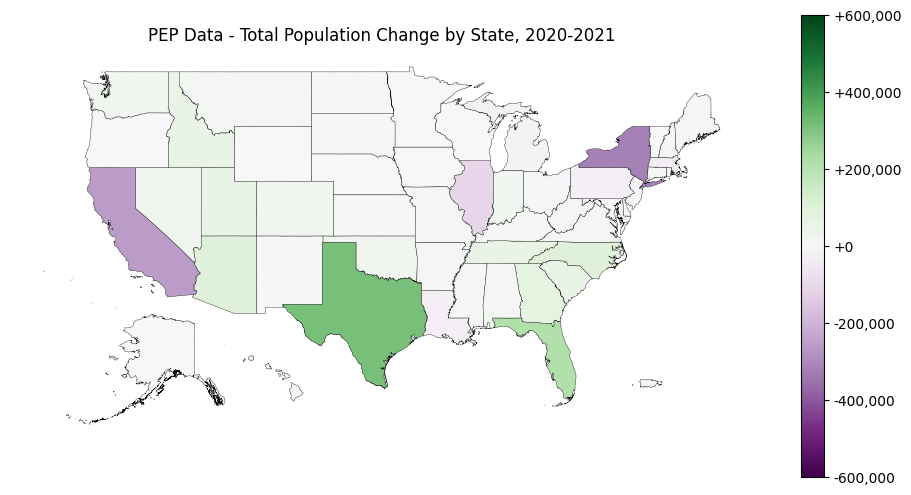

In [22]:
from matplotlib.ticker import FuncFormatter

ax = cem.plot_us(
    gdf_pep,
    NUM_CHANGE_VARIABLE,
    legend=True,
    figsize=(12, 6),
    cmap="PRGn",
    edgecolor="black",
    linewidth=0.25,
    vmin=-600_000,
    vmax=600_000,
    legend_kwds={"format": FuncFormatter(lambda x, pos: f"{x:+,.0f}")},
)

ax.axis("off")
ax.set_title("PEP Data - Total Population Change by State, 2020-2021")

Text(0.5, 1.0, 'PEP Data - Total Population Percentage Change by State, 2020-2021')

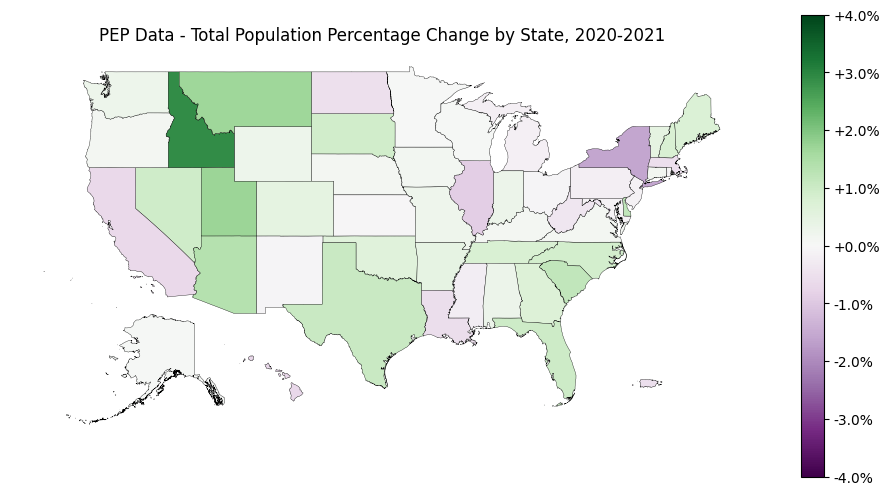

In [23]:
ax = cem.plot_us(
    gdf_pep,
    PCT_CHANGE_VARIABLE,
    legend=True,
    figsize=(12, 6),
    cmap="PRGn",
    edgecolor="black",
    linewidth=0.25,
    vmin=-4,
    vmax=4,
    legend_kwds={"format": FuncFormatter(lambda x, pos: f"{x:+.1f}%")},
)

ax.axis("off")
ax.set_title("PEP Data - Total Population Percentage Change by State, 2020-2021")

# Part 3. Compare NY Results

In [24]:
gdf_both_years[gdf_both_years.STATE == STATE_NY][
    ["NAME", TOTAL_POPULATION_CHANGE, TOTAL_POPULATION_CHANGE_PERCENT]
]

,NAME,B01003_001E_DELTA,B01003_001E_DELTA_PERCENT
4,New York,599896,3.074049


In [25]:
gdf_pep[gdf_pep.STATE == STATE_NY][["NAME", NUM_CHANGE_VARIABLE, PCT_CHANGE_VARIABLE]]

,NAME,NPOPCHG_2021,PPOPCHG_2021
37,New York,-319020,-1.582838
